# Minimize input model

This notebook can experiment with the input data. such as training only on the sequence, energy terms, or remove some of the sequences such as mhc or peptide

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from network import Test
import pandas as pd

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

########### Select Indexes ############

# Full model
#idx = np.arange(420)

# peptide + TCR
idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
#idx = np.arange(192)

########### Select Features ###########

# All features
local_features = np.arange(27)
global_features = np.arange(27, 54)
use_global_features = True

# Sequence
#local_features = np.arange(20)
#global_features = None
#use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True

net = Test(local_features, global_features, use_global_features)
net.to(device)
print(net)
print("Using Device:", device)


Test(
  (conv1): Conv1d(27, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=127, out_features=60, bias=True)
  (dense2): Linear(in_features=60, out_features=60, bias=True)
  (dense3): Linear(in_features=60, out_features=1, bias=True)
  (bn_start): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (heavy_drop): Dropout(p=0.7, inplace=False)
)
Using Device: cpu


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])

train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()

ValueError: axes don't match array

In [ ]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [ ]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [ ]:
train_data.data.shape

(4174, 420, 54)

In [8]:
#Hyperparameters
epochs = 100
patience = 15
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
model_name = "minimize_input.pt"


# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=0.0005,
    amsgrad=True
)

stopper = EarlyStopping(patience, model_name)
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [9]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 1
Train loss: 0.43357109301017993 Train MCC: -0.006927195956345739 Train AUC: 0.49322852702460884
Validation loss: 0.26085929075876874 Validation MCC: 0.0 Validation AUC: 0.39490009475829824
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 2
Train loss: 0.27594390059962415 Train MCC: -0.012773258789384364 Train AUC: 0.49151658442478485
Validation loss: 0.2606816291809082 Validation MCC: 0.0 Validation AUC: 0.43884567577209826
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 3
Train loss: 0.2638215729684541 Train MCC: -0.0058292251684692814 Train AUC: 0.5024576043711989
Validation loss: 0.2603951295216878 Validation MCC: 0.0 Validation AUC: 0.5
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 4
Train loss: 0.2634183999263879 Train MCC: -0.006755402083309036 Train AUC: 0.4974074196640217
Validation loss: 0.2601666251818339 Validation MCC: 0.0 Validation AUC: 0.4269770284979333
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 5
Train loss: 0.26217258337772253 Train MCC: 0.0006505627236961063 Train AUC: 0.49450398094831877
Validation loss: 0.25994813442230225 Validation MCC: 0.0 Validation AUC: 0.4995648389904265
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 6
Train loss: 0.26169268290201825 Train MCC: -0.006452069142913961 Train AUC: 0.4870185601910071
Validation loss: 0.259876012802124 Validation MCC: 0.0 Validation AUC: 0.428140487698464
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 7
Train loss: 0.2607910560839104 Train MCC: -0.004670869302530591 Train AUC: 0.49536699980144283
Validation loss: 0.25985272725423175 Validation MCC: 0.0 Validation AUC: 0.4720076715591035
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 8
Train loss: 0.260425278634736 Train MCC: 0.010405480862636948 Train AUC: 0.5062409147846636
Validation loss: 0.259834885597229 Validation MCC: 0.0 Validation AUC: 0.6004028931958089
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 9
Train loss: 0.2601909637451172 Train MCC: -0.007268174922920522 Train AUC: 0.5008038806892139
Validation loss: 0.25981024901072186 Validation MCC: 0.0 Validation AUC: 0.5428605189664302
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 10
Train loss: 0.26036141135475854 Train MCC: -0.0055425091077672215 Train AUC: 0.4978362479562095
Validation loss: 0.2597762544949849 Validation MCC: 0.0 Validation AUC: 0.5326404842898922
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 11
Train loss: 0.2606773376464844 Train MCC: 0.007824536742281814 Train AUC: 0.4998051198329178
Validation loss: 0.25976963837941486 Validation MCC: 0.0 Validation AUC: 0.625810387963651
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 12
Train loss: 0.25998696413907135 Train MCC: 0.015134324543540176 Train AUC: 0.49976697112096546
Validation loss: 0.25977442661921185 Validation MCC: 0.0 Validation AUC: 0.4833820759111681
Early Stopping Counter: 1 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 13
Train loss: 0.26015192089658795 Train MCC: -0.012541830112061671 Train AUC: 0.4916169354542178
Validation loss: 0.25977351268132526 Validation MCC: 0.0 Validation AUC: 0.4648144487089466
Early Stopping Counter: 2 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 14
Train loss: 0.26033791628750885 Train MCC: -0.008113120355392626 Train AUC: 0.4842364619566949
Validation loss: 0.25976695617039997 Validation MCC: 0.0 Validation AUC: 0.5463270365648868
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 15
Train loss: 0.2600873600352894 Train MCC: -0.03175156549217673 Train AUC: 0.4832718664127096
Validation loss: 0.2597658038139343 Validation MCC: 0.0 Validation AUC: 0.5681498499092184
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 16
Train loss: 0.25993916482636426 Train MCC: 0.008665324416741131 Train AUC: 0.5008440211009871
Validation loss: 0.25976528724034625 Validation MCC: 0.0 Validation AUC: 0.6092879038873626
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 17
Train loss: 0.2599275762384588 Train MCC: -0.004912534344539618 Train AUC: 0.4908482925310644
Validation loss: 0.2597663402557373 Validation MCC: 0.0 Validation AUC: 0.5417743207284346
Early Stopping Counter: 1 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 18
Train loss: 0.2598650094234582 Train MCC: -0.015449854913868103 Train AUC: 0.48994773779670203
Validation loss: 0.2597667376200358 Validation MCC: 0.0 Validation AUC: 0.5938607075740739
Early Stopping Counter: 2 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 19
Train loss: 0.26001554546934186 Train MCC: -0.02005819673079952 Train AUC: 0.4868722468580169
Validation loss: 0.2597673137982686 Validation MCC: 0.0 Validation AUC: 0.5547996100593774
Early Stopping Counter: 3 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 20
Train loss: 0.2599855191779859 Train MCC: -0.03362170612866347 Train AUC: 0.4838506850221722
Validation loss: 0.2597646315892537 Validation MCC: 0.0 Validation AUC: 0.48705878877534553
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 21
Train loss: 0.25992384823885833 Train MCC: -0.03811600532143633 Train AUC: 0.4840925999465612
Validation loss: 0.2597618103027344 Validation MCC: 0.0 Validation AUC: 0.6082198846993754
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 22
Train loss: 0.2599244262232925 Train MCC: -0.02336163538360521 Train AUC: 0.487470522842652
Validation loss: 0.2597596247990926 Validation MCC: 0.0 Validation AUC: 0.5845598511135803
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 23
Train loss: 0.259946447430235 Train MCC: -0.007717883458907909 Train AUC: 0.48452801616892555
Validation loss: 0.2597588499387105 Validation MCC: 0.0 Validation AUC: 0.5847620930449227
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 24
Train loss: 0.2600249666156191 Train MCC: -0.025126266710350613 Train AUC: 0.47930501320037355
Validation loss: 0.25976260503133136 Validation MCC: 0.0 Validation AUC: 0.5634778340570867
Early Stopping Counter: 1 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 25
Train loss: 0.2600171927249793 Train MCC: -0.028007852360156665 Train AUC: 0.47643696545840963
Validation loss: 0.25976383686065674 Validation MCC: 0.0 Validation AUC: 0.5624120872503505
Early Stopping Counter: 2 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 26
Train loss: 0.2599733526056463 Train MCC: -0.023899287771000994 Train AUC: 0.47266177505190676
Validation loss: 0.2597614924112956 Validation MCC: 0.0 Validation AUC: 0.4077560916860387
Early Stopping Counter: 3 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 27
Train loss: 0.2599266803625858 Train MCC: -0.014940601354861012 Train AUC: 0.4848715077841757
Validation loss: 0.2597607771555583 Validation MCC: 0.0 Validation AUC: 0.5416073007064832
Early Stopping Counter: 4 out of 15


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 28
Train loss: 0.2599381822528261 Train MCC: -0.01933972754855705 Train AUC: 0.4824166611511903
Validation loss: 0.2597611943880717 Validation MCC: 0.0 Validation AUC: 0.38544017161023203
Early Stopping Counter: 5 out of 15


KeyboardInterrupt: 

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

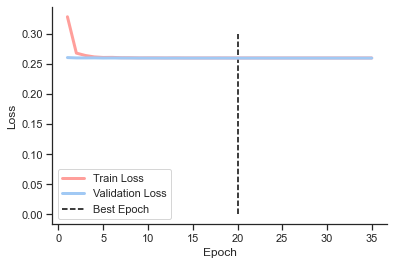

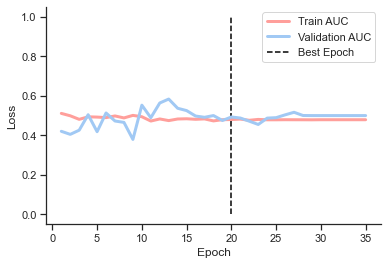

In [10]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [11]:
final_model = Test(local_features, global_features, use_global_features)
final_model.load_state_dict(torch.load("early_stopping_state.pt"))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [12]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Evaluation on Training Data:
Loss: 0.2598233367457534
MCC: 0.0
Confussion Matrix:
 [[   0 3132]
 [   0 1042]] 

Evaluation on Validation Data:
Loss: 0.2597521146138509
MCC: 0.0
Confussion Matrix:
 [[   0 1149]
 [   0  383]] 

Evaluation on Test Data:
Loss: 0.25948996292917353
MCC: 0.0
Confussion Matrix:
 [[  0 906]
 [  0 301]] 



/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Text(0.5, 1.0, 'Test Data')

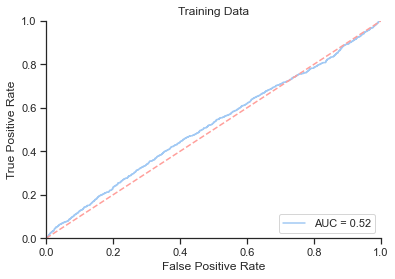

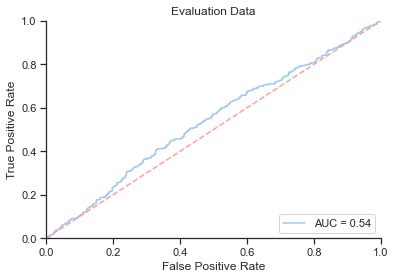

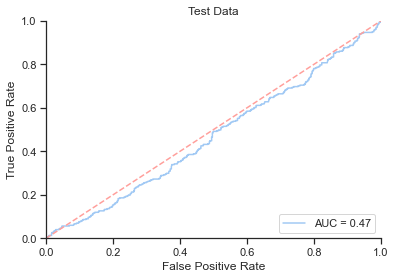

In [13]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")


In [13]:
arrays=[np.array(["all_feat", "all_feat", "all_feat", "all_feat", "all_feat",
       "sequence", "sequence", "sequence", "sequence", "sequence",
       "energy_terms", "energy_terms", "energy_terms", "energy_terms", "energy_terms",
       "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy"])
       ,
       np.array(["full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc"])]

results= pd.DataFrame({"auc_train" : [0.95, 0.96, 0.91, 0.88, 0.60, 0.92, 0.95, 0.77, 0.76, 0.60, 0.94, 0.94, 0.93, 0.92, 0.88, 0.95, 0.94, 0.78, 0.77, 0.70],
                       "auc_val" : [0.91, 0.91, 0.84, 0.79, 0.62, 0.90, 0.90, 0.72, 0.73, 0.61, 0.87, 0.89, 0.85, 0.79, 0.82, 0.89, 0.90, 0.73, 0.72, 0.71],
                       "auc_test" : [0.86, 0.86, 0.78, 0.76, 0.54, 0.87, 0.87, 0.70, 0.70, 0.57, 0.83, 0.85, 0.81, 0.74, 0.78, 0.85, 0.87, 0.70, 0.70, 0.63],
                       "mcc_train" : [0.75, 0.70, 0.69, 0.55, 0.095, 0.63, 0.61, 0.36, 0.37, 0.18, 0.72, 0.61, 0.67, 0.62, 0.62, 0.72, 0.60, 0.38, 0.39, 0.00228],
                       "mcc_val" : [0.63, 0.56, 0.58, 0.45, 0.14, 0.54, 0.55, 0.32, 0.32, 0.18, 0.58, 0.51, 0.57, 0.44, 0.54, 0.65, 0.52, 0.33, 0.32, 0.00223], 
                       "mcc_test" : [0.54, 0.52, 0.51, 0.41, 0.047, 0.49, 0.47, 0.31, 0.31, 0.12, 0.52, 0.47, 0.53, 0.37, 0.49, 0.59, 0.49, 0.31, 0.30, 0.00169]}, index=arrays)
results

auc_train  auc_val  auc_test  mcc_train  \
all_feat         full_model        0.95     0.91      0.86    0.75000   
                 peptide_tcr       0.96     0.91      0.86    0.70000   
                 mhc_tcr           0.91     0.84      0.78    0.69000   
                 tcr               0.88     0.79      0.76    0.55000   
                 peptide_mhc       0.60     0.62      0.54    0.09500   
sequence         full_model        0.92     0.90      0.87    0.63000   
                 peptide_tcr       0.95     0.90      0.87    0.61000   
                 mhc_tcr           0.77     0.72      0.70    0.36000   
                 tcr               0.76     0.73      0.70    0.37000   
                 peptide_mhc       0.60     0.61      0.57    0.18000   
energy_terms     full_model        0.94     0.87      0.83    0.72000   
                 peptide_tcr       0.94     0.89      0.85    0.61000   
                 mhc_tcr           0.93     0.85      0.81    0.67000   
                 tcr               0.92     0.79      0.74    0.62000   
                 peptide_mhc       0.88     0.82      0.78    0.62000   
seq_globalenergy full_model        0.95     0.89      0.85    0.72000   
                 peptide_tcr       0.94     0.90      0.87    0.60000   
                 mhc_tcr           0.78     0.73      0.70    0.38000   
                 tcr               0.77     0.72      0.70    0.39000   
                 peptide_mhc       0.70     0.71      0.63    0.00228   

                              mcc_val  mcc_test  
all_feat         full_model   0.63000   0.54000  
                 peptide_tcr  0.56000   0.52000  
                 mhc_tcr      0.58000   0.51000  
                 tcr          0.45000   0.41000  
                 peptide_mhc  0.14000   0.04700  
sequence         full_model   0.54000   0.49000  
                 peptide_tcr  0.55000   0.47000  
                 mhc_tcr      0.32000   0.31000  
                 tcr          0.32000   0.31000  
                 peptide_mhc  0.18000   0.12000  
energy_terms     full_model   0.58000   0.52000  
                 peptide_tcr  0.51000   0.47000  
                 mhc_tcr      0.57000   0.53000  
                 tcr          0.44000   0.37000  
                 peptide_mhc  0.54000   0.49000  
seq_globalenergy full_model   0.65000   0.59000  
                 peptide_tcr  0.52000   0.49000  
                 mhc_tcr      0.33000   0.31000  
                 tcr          0.32000   0.30000  
                 peptide_mhc  0.00223   0.00169

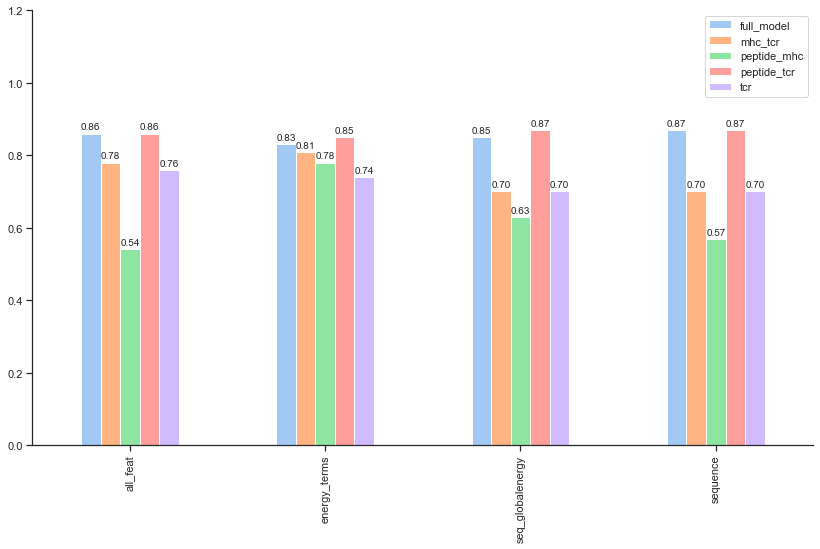

In [75]:
plt.figure(figsize=(14,8))
ax = plt.gca()
results["auc_test"].unstack().plot(kind='bar', ax=ax, ylim=(0,1.2))
for container in ax.containers:
    ax.bar_label(container, padding=2, fmt="%.2f", fontsize=10)


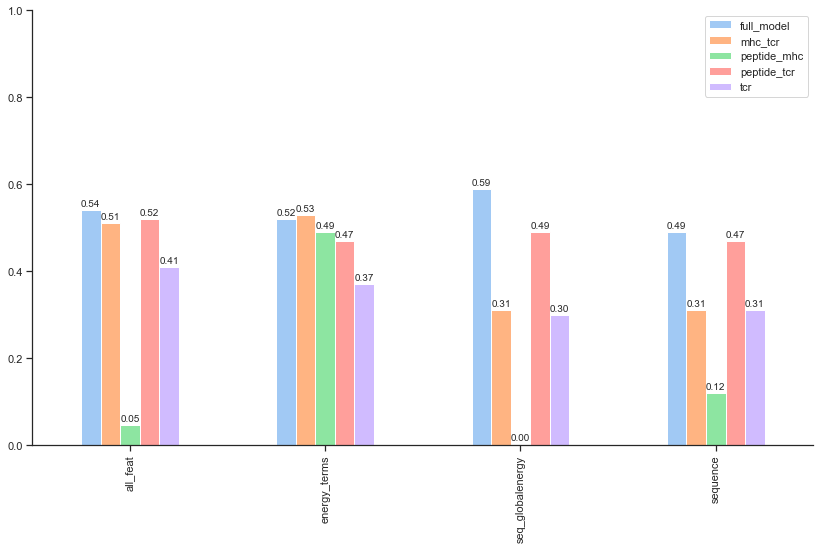

In [74]:
plt.figure(figsize=(14,8))
ax = plt.gca()
results["mcc_test"].unstack().plot(kind='bar', ax=ax, ylim=(0,1))
for container in ax.containers:
    ax.bar_label(container, padding=2, fmt="%.2f", fontsize=10)